In [1]:
import sys
import os
workspace_path = os.path.join(os.path.abspath(".."))
sys.path.append(workspace_path)
workspace_path

'c:\\Users\\Kajsa\\VSCodeProjects\\job_discrimination'

In [2]:
import pandas as pd
from pandas.core.frame import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
import warnings
warnings.simplefilter("ignore")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# Local imports
from src.helpers import *

In [3]:
pd.options.display.float_format = "{:.2f}".format

In [4]:
path_to_cleaned_data = os.path.join(workspace_path, "data", "cleaned_data")
file_dir = os.path.join(path_to_cleaned_data, "Job_Bulletins", "labeled", "*")
file_paths = glob.glob(file_dir)

In [5]:
# Reading application statistics into dataframe
file_path = os.path.join(path_to_cleaned_data, "applicants.csv")
df = pd.read_csv(file_path, dtype={"ID": str})
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt
...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt


In [6]:
# Replacing old file names with cleaned versions
df["File Names"] = df["Job Description"] + " " + df["ID"]
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400
...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 4123
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912


In [7]:
# Getting bulletin texts and lemmatizing them
file_names, contents = get_contents(file_paths)
contents_lemmatized = lemmatize(contents)

In [8]:
df_content = pd.DataFrame({"File Names": file_names, "lemmatized_contents": contents_lemmatized})

In [9]:
df_content

,File Names,lemmatized_contents
0,311 DIRECTOR 9206,director class code open date annual salary du...
1,ACCOUNTING CLERK 1223,accounting clerk class code open date exam ope...
2,AIR CONDITIONING MECHANIC 3774,air condition mechanic class code open date ex...
3,AIRPORT MANAGER 7260,airport manager class code open date exam open...
4,AIRPORT POLICE LIEUTENANT 3227,airport police lieutenant class code open date...
...,...,...
172,WATERWORKS MECHANIC SUPERVISOR 3987,waterworks mechanic supervisor class code open...
173,WELDER 3796,welder class code open date exam open include ...
174,WHARFINGER 1190,wharfinger class code open date exam open incl...
175,WORKERS COMPENSATION ANALYST 1774,worker compensation analyst class code open da...


In [10]:
df = df.merge(df_content, how="inner", on="File Names")

In [11]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,lemmatized_contents
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206,director class code open date annual salary du...
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223,accounting clerk class code open date exam ope...
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260,airport manager class code open date exam open...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227,airport police lieutenant class code open date...
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400,aquarist class code open date annual salary ca...
...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840,wastewater treatment laboratory manager class ...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 4123,wastewater treatment operator class code open ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857,water microbiologist class code open date revi...
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912,water utility worker class code open date exam...


In [12]:
# Create and add labels
mostly_women = df["Female"] >= (df["Apps Received"] - df["Unknown_Gender"]) * 0.6
mostly_men = df["Male"] >= (df["Apps Received"] - df["Unknown_Gender"]) * 0.6
neutral = (df["Female"] < (df["Apps Received"] - df["Unknown_Gender"]) * 0.6) & (df["Female"] > (df["Apps Received"] - df["Unknown_Gender"]) * 0.4)

In [13]:
labels = []
for i in range(len(df)):
    if mostly_women[i]:
        label = "W"
    elif mostly_men[i]:
        label = "M"
    elif neutral[i]:
        label = "N"
    else:
        label = None
    labels.append(label)
df["Labels"] = labels


In [14]:
df["Labels"].value_counts()

M    126
N     32
W     19
Name: Labels, dtype: int64

In [15]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,lemmatized_contents,Labels
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206,director class code open date annual salary du...,M
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223,accounting clerk class code open date exam ope...,W
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260,airport manager class code open date exam open...,M
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227,airport police lieutenant class code open date...,M
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400,aquarist class code open date annual salary ca...,M
...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840,wastewater treatment laboratory manager class ...,M
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 4123,wastewater treatment operator class code open ...,M
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857,water microbiologist class code open date revi...,N
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912,water utility worker class code open date exam...,M


In [16]:
df.isnull().sum()

ID                     0
Job Description        0
Apps Received          0
Female                 0
Male                   0
Unknown_Gender         0
File Names             0
lemmatized_contents    0
Labels                 0
dtype: int64

In [17]:
df.dropna(how="any", inplace=True)
df.reset_index(inplace=True, drop=True)
df.drop(columns=["Apps Received", "Female", "Male", "Unknown_Gender"], inplace=True)

In [18]:
df

,ID,Job Description,File Names,lemmatized_contents,Labels
0,9206,311 DIRECTOR,311 DIRECTOR 9206,director class code open date annual salary du...,M
1,1223,ACCOUNTING CLERK,ACCOUNTING CLERK 1223,accounting clerk class code open date exam ope...,W
2,7260,AIRPORT MANAGER,AIRPORT MANAGER 7260,airport manager class code open date exam open...,M
3,3227,AIRPORT POLICE LIEUTENANT,AIRPORT POLICE LIEUTENANT 3227,airport police lieutenant class code open date...,M
4,2400,AQUARIST,AQUARIST 2400,aquarist class code open date annual salary ca...,M
...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,WASTEWATER TREATMENT LABORATORY MANAGER 7840,wastewater treatment laboratory manager class ...,M
173,4123,WASTEWATER TREATMENT OPERATOR,WASTEWATER TREATMENT OPERATOR 4123,wastewater treatment operator class code open ...,M
174,7857,WATER MICROBIOLOGIST,WATER MICROBIOLOGIST 7857,water microbiologist class code open date revi...,N
175,3912,WATER UTILITY WORKER,WATER UTILITY WORKER 3912,water utility worker class code open date exam...,M


In [20]:
X = df["lemmatized_contents"]
y = df["Labels"]

In [21]:
# Initializing a vectorizer in order to transform the text to numbers
# # Stop words already removed in "lemmatizer"?
# vect = CountVectorizer(stop_words="english")

vect = TfidfVectorizer(max_features=2500)

In [23]:
# .todense() probably not applicable in this case, since no null-values are present
X = vect.fit_transform(X).todense()

In [43]:
vect.get_feature_names()
X.shape

(177, 2500)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
model = RandomForestClassifier(max_depth=4, random_state=0)

In [27]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [28]:
y_pred = model.predict(X_test)

In [29]:
y_pred

array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M'], dtype=object)

In [30]:
accuracy = accuracy_score(y_pred, y_test) * 100
print(f"Accuracy of the model is {'{:.2f}'.format(accuracy)}")

Accuracy of the model is 71.11


In [31]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=model.classes_)

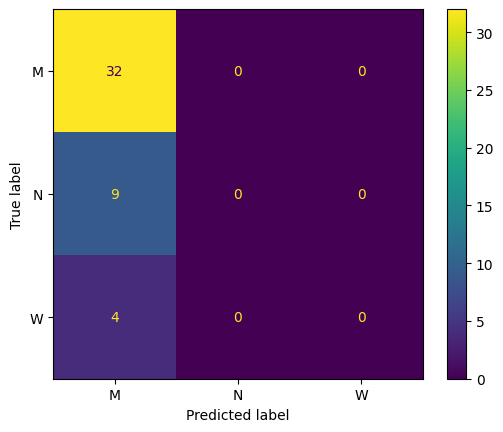

In [32]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plot.plot()
plt.show()

In [33]:
scores = cross_val_score(model, X, y, cv=5)
scores


array([0.72222222, 0.72222222, 0.71428571, 0.71428571, 0.71428571])

In [34]:
# Standard deviation: The spread of values. 
# High standard deviation implies high spread of accuracies between cross-validation folds
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.72 accuracy with a standard deviation of 0.00


In [35]:
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
other_scores = cross_val_score(model, X, y, cv=cv)
other_scores

array([0.64814815, 0.75925926, 0.75925926, 0.66666667, 0.7962963 ])

In [36]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (other_scores.mean(), other_scores.std()))

0.73 accuracy with a standard deviation of 0.06


In [37]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}